<a href="https://colab.research.google.com/github/biki321/StyleTransfer/blob/master/style_transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%matplotlib inline

from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.optim as optim
import requests
from torchvision import transforms, models

In [0]:
# get the "features" portion of VGG19 (we will not need the "classifier" portion)
vgg = models.vgg19(pretrained=True).features

# freeze all VGG parameters since we're only optimizing the target image
for param in vgg.parameters():
    param.requires_grad_(False)

In [71]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

vgg.to(device)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [0]:
cImPath = '/content/drive/My Drive/Colab Notebooks/imp colab/Style_Transfer/IMG-20200309-WA0006.jpg'
#sImPath = '/content/drive/My Drive/Colab Notebooks/imp colab/Style_Transfer/style_image.jpg'
sImPath = '/content/drive/My Drive/Colab Notebooks/imp colab/Style_Transfer/style2.jpg'
def load_image(img_path, max_size=400, shape=None):
    ''' Load in and transform an image, making sure the image
       is <= 400 pixels in the x-y dims.'''
    if "http" in img_path:
        response = requests.get(img_path)
        image = Image.open(BytesIO(response.content)).convert('RGB')
    else:
        image = Image.open(img_path).convert('RGB')
    
    # large images will slow down processing
    if max(image.size) > max_size:
        size = max_size
    else:
        size = max(image.size)
    
    if shape is not None:
        size = shape
        
    in_transform = transforms.Compose([
                        transforms.Resize(size),
                        transforms.ToTensor(),
                        transforms.Normalize((0.485, 0.456, 0.406), 
                                             (0.229, 0.224, 0.225))])

    # discard the transparent, alpha channel (that's the :3) and add the batch dimension
    image = in_transform(image)[:3,:,:].unsqueeze(0)

    return image

In [0]:
content = load_image(cImPath).to(device)
style = load_image(sImPath, shape=content.shape[-2:]).to(device)

In [0]:

# helper function for un-normalizing an image 
# and converting it from a Tensor image to a NumPy image for display
def im_convert(tensor):
    """ Display a tensor as an image. """
    
    image = tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1,2,0)
    image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
    image = image.clip(0, 1)

    return image

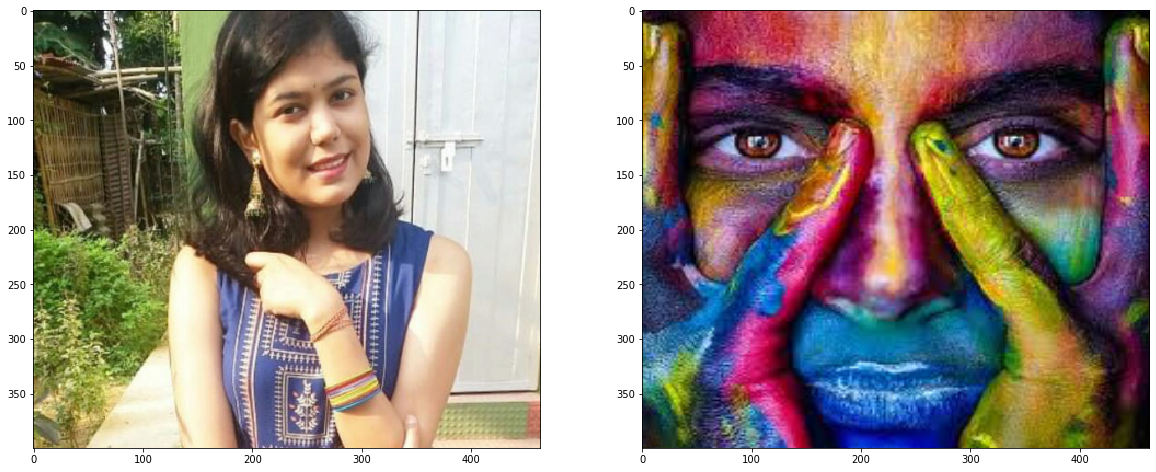

In [75]:
# display the images
fig, axes = plt.subplots(1, 2, figsize=(20, 10) , squeeze=False)
# content and style ims side-by-side
axes[0, 0].imshow(im_convert(content))
axes[0, 1].imshow(im_convert(style))


In [0]:
def get_features(image, model, layers=None):
    """ Run an image forward through a model and get the features for 
        a set of layers. Default layers are for VGGNet matching Gatys et al (2016)
    """
    
    ## TODO: Complete mapping layer names of PyTorch's VGGNet to names from the paper
    ## Need the layers for the content and style representations of an image
    if layers is None:
        layers = {'0': 'conv1_1',
                  '5': 'conv2_1', 
                  '10': 'conv3_1', 
                  '19': 'conv4_1',
                  '21': 'conv4_2',  ## content representation
                  '28': 'conv5_1'}
        
    features = {}
    x = image
    # model._modules is a dictionary holding each module in the model
    for name, layer in model._modules.items():
        x = layer(x)
        if name in layers:
            features[layers[name]] = x
            
    return features


In [0]:
def gram_matrix(tensor):
    """ Calculate the Gram Matrix of a given tensor 
        Gram Matrix: https://en.wikipedia.org/wiki/Gramian_matrix
    """
    
    # get the batch_size, depth, height, and width of the Tensor
    _, d, h, w = tensor.size()
    
    # reshape so we're multiplying the features for each channel
    tensor = tensor.view(d, h * w)
    
    # calculate the gram matrix
    gram = torch.mm(tensor, tensor.t())
    
    return gram

In [0]:
# get content and style features only once before training
content_features = get_features(content, vgg)
style_features = get_features(style, vgg)

# calculate the gram matrices for each layer of our style representation
style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features}

# create a third "target" image and prep it for change
# it is a good idea to start off with the target as a copy of our *content* image
# then iteratively change its style
target = content.clone().requires_grad_(True).to(device)

In [0]:

# weights for each style layer 
# weighting earlier layers more will result in *larger* style artifacts
# notice we are excluding `conv4_2` our content representation
style_weights = {'conv1_1': 1.,
                 'conv2_1': 0.75,
                 'conv3_1': 0.2,
                 'conv4_1': 0.2,
                 'conv5_1': 0.2}

content_weight = 1  # alpha
style_weight = 1e6  # beta

Iteration = 1 , loss = 197657936.0
Iteration = 2 , loss = 194768368.0
Iteration = 3 , loss = 192224272.0
Iteration = 4 , loss = 189911232.0
Iteration = 5 , loss = 187753568.0
Iteration = 6 , loss = 185712624.0
Iteration = 7 , loss = 183761584.0
Iteration = 8 , loss = 181881840.0
Iteration = 9 , loss = 180060368.0
Iteration = 10 , loss = 178287760.0
Iteration = 11 , loss = 176557616.0
Iteration = 12 , loss = 174867200.0
Iteration = 13 , loss = 173212400.0
Iteration = 14 , loss = 171589872.0
Iteration = 15 , loss = 169997728.0
Iteration = 16 , loss = 168434480.0
Iteration = 17 , loss = 166899440.0
Iteration = 18 , loss = 165390432.0
Iteration = 19 , loss = 163906368.0
Iteration = 20 , loss = 162445504.0
Iteration = 21 , loss = 161007152.0
Iteration = 22 , loss = 159590560.0
Iteration = 23 , loss = 158193808.0
Iteration = 24 , loss = 156815728.0
Iteration = 25 , loss = 155456192.0
Iteration = 26 , loss = 154114624.0
Iteration = 27 , loss = 152790672.0
Iteration = 28 , loss = 151482960.0
I

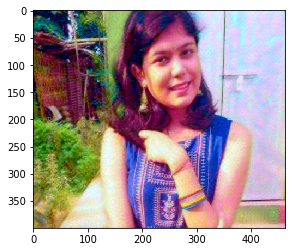

Iteration = 401 , loss = 18009566.0
Iteration = 402 , loss = 17928604.0
Iteration = 403 , loss = 17847914.0
Iteration = 404 , loss = 17767500.0
Iteration = 405 , loss = 17687348.0
Iteration = 406 , loss = 17607472.0
Iteration = 407 , loss = 17527876.0
Iteration = 408 , loss = 17448548.0
Iteration = 409 , loss = 17369504.0
Iteration = 410 , loss = 17290730.0
Iteration = 411 , loss = 17212244.0
Iteration = 412 , loss = 17134044.0
Iteration = 413 , loss = 17056112.0
Iteration = 414 , loss = 16978460.0
Iteration = 415 , loss = 16901114.0
Iteration = 416 , loss = 16824058.0
Iteration = 417 , loss = 16747284.0
Iteration = 418 , loss = 16670786.0
Iteration = 419 , loss = 16594584.0
Iteration = 420 , loss = 16518664.0
Iteration = 421 , loss = 16443045.0
Iteration = 422 , loss = 16367729.0
Iteration = 423 , loss = 16292702.0
Iteration = 424 , loss = 16217976.0
Iteration = 425 , loss = 16143544.0
Iteration = 426 , loss = 16069399.0
Iteration = 427 , loss = 15995547.0
Iteration = 428 , loss = 159

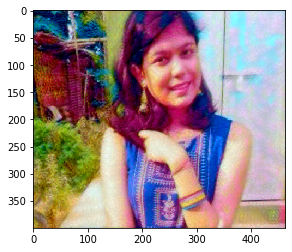

Iteration = 801 , loss = 4691744.0
Iteration = 802 , loss = 4682734.5
Iteration = 803 , loss = 4673761.5
Iteration = 804 , loss = 4664823.0
Iteration = 805 , loss = 4655917.0
Iteration = 806 , loss = 4647043.0
Iteration = 807 , loss = 4638205.0
Iteration = 808 , loss = 4629396.0
Iteration = 809 , loss = 4620620.5
Iteration = 810 , loss = 4611879.0
Iteration = 811 , loss = 4603170.0
Iteration = 812 , loss = 4594494.0
Iteration = 813 , loss = 4585847.0
Iteration = 814 , loss = 4577236.0
Iteration = 815 , loss = 4568655.0
Iteration = 816 , loss = 4560104.5
Iteration = 817 , loss = 4551582.5
Iteration = 818 , loss = 4543095.5
Iteration = 819 , loss = 4534639.0
Iteration = 820 , loss = 4526210.5
Iteration = 821 , loss = 4517813.0
Iteration = 822 , loss = 4509450.0
Iteration = 823 , loss = 4501114.5
Iteration = 824 , loss = 4492807.0
Iteration = 825 , loss = 4484531.5
Iteration = 826 , loss = 4476286.5
Iteration = 827 , loss = 4468069.0
Iteration = 828 , loss = 4459881.5
Iteration = 829 , lo

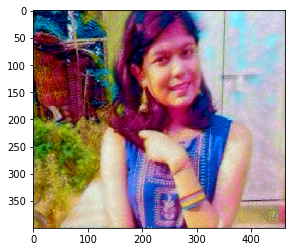

Iteration = 1201 , loss = 2608320.25
Iteration = 1202 , loss = 2605278.5
Iteration = 1203 , loss = 2602242.25
Iteration = 1204 , loss = 2599212.5
Iteration = 1205 , loss = 2596187.0
Iteration = 1206 , loss = 2593168.75
Iteration = 1207 , loss = 2590157.0
Iteration = 1208 , loss = 2587149.5
Iteration = 1209 , loss = 2584148.75
Iteration = 1210 , loss = 2581154.75
Iteration = 1211 , loss = 2578165.25
Iteration = 1212 , loss = 2575181.75
Iteration = 1213 , loss = 2572204.75
Iteration = 1214 , loss = 2569235.5
Iteration = 1215 , loss = 2566270.5
Iteration = 1216 , loss = 2563310.75
Iteration = 1217 , loss = 2560357.0
Iteration = 1218 , loss = 2557409.75
Iteration = 1219 , loss = 2554467.75
Iteration = 1220 , loss = 2551531.0
Iteration = 1221 , loss = 2548600.5
Iteration = 1222 , loss = 2545676.0
Iteration = 1223 , loss = 2542758.0
Iteration = 1224 , loss = 2539843.75
Iteration = 1225 , loss = 2536934.75
Iteration = 1226 , loss = 2534031.75
Iteration = 1227 , loss = 2531135.5
Iteration = 12

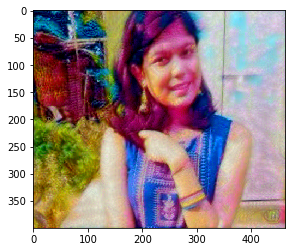

Iteration = 1601 , loss = 1737711.75
Iteration = 1602 , loss = 1736149.25
Iteration = 1603 , loss = 1734588.125
Iteration = 1604 , loss = 1733029.125
Iteration = 1605 , loss = 1731472.25
Iteration = 1606 , loss = 1729917.5
Iteration = 1607 , loss = 1728365.25
Iteration = 1608 , loss = 1726815.125
Iteration = 1609 , loss = 1725266.0
Iteration = 1610 , loss = 1723719.125
Iteration = 1611 , loss = 1722176.625
Iteration = 1612 , loss = 1720633.375
Iteration = 1613 , loss = 1719093.5
Iteration = 1614 , loss = 1717555.5
Iteration = 1615 , loss = 1716019.125
Iteration = 1616 , loss = 1714484.375
Iteration = 1617 , loss = 1712952.75
Iteration = 1618 , loss = 1711423.125
Iteration = 1619 , loss = 1709895.0
Iteration = 1620 , loss = 1708369.375
Iteration = 1621 , loss = 1706847.125
Iteration = 1622 , loss = 1705326.5
Iteration = 1623 , loss = 1703806.875
Iteration = 1624 , loss = 1702291.0
Iteration = 1625 , loss = 1700776.125
Iteration = 1626 , loss = 1699263.125
Iteration = 1627 , loss = 16977

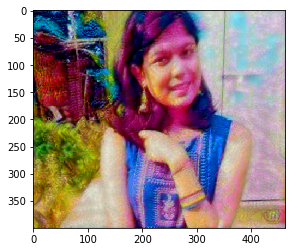

In [80]:
# for displaying the target image, intermittently
show_every = 400

# iteration hyperparameters
optimizer = optim.Adam([target], lr=0.003)
steps = 2000  # decide how many iterations to update your image (5000)

for ii in range(1, steps+1):
    
    # get the features from your target image
    target_features = get_features(target, vgg)
    
    # the content loss
    content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2'])**2)
    
    # the style loss
    # initialize the style loss to 0
    style_loss = 0
    # then add to it for each layer's gram matrix loss
    for layer in style_weights:
        # get the "target" style representation for the layer
        target_feature = target_features[layer]
        target_gram = gram_matrix(target_feature)
        _, d, h, w = target_feature.shape
        # get the "style" style representation
        style_gram = style_grams[layer]
        # the style loss for one layer, weighted appropriately
        layer_style_loss = style_weights[layer] * torch.mean((target_gram - style_gram)**2)
        # add to the style loss
        style_loss += layer_style_loss / (d * h * w)
        
    # calculate the *total* loss
    total_loss = content_weight * content_loss + style_weight * style_loss
    
    # update your target image
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()
    print( "Iteration = {} , loss = {}".format(ii, total_loss.item()) )
    
    # display intermediate images and print the loss
    if  ii % show_every == 0:
        print('Total loss: ', total_loss.item())
        plt.imshow(im_convert(target))
        plt.show()

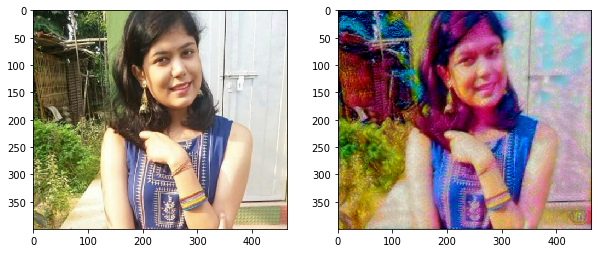

In [82]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.imshow(im_convert(content))
ax2.imshow(im_convert(target))